In [4]:
import numpy as np
import glob
import os
import json

dataset_paths = ["./results/20210526_MCF7_fn", "./results/20210526_LCLC_fn"]

def read_dataset(dataset_path: str):
  seg_paths = glob.glob(os.path.join(dataset_path, "*.npz"))

  result = {}
  for seg_path in seg_paths:
    key = os.path.basename(seg_path).split("_seg.npz")[0]
    params_path = os.path.join(dataset_path, f"metadata/{key}_params.json")

    seg = np.load(seg_path, allow_pickle=True)
    with open(params_path, "r") as file:
      params = json.load(file)

    result[key] = [np.max(seg["well"], axis=0), seg["im_markers"], params["scale"] / 80, params["t_0"], params["t_1"]]
  
  return result

# Cell count normalization

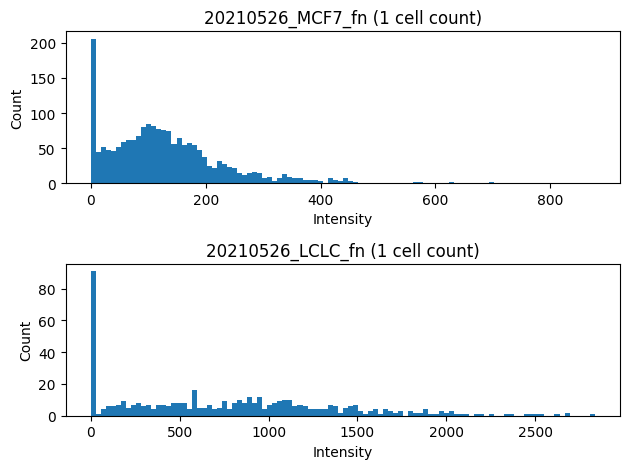

In [6]:
import matplotlib.pyplot as plt
from utils import calculate_microscope_cell_centroids

fig, ax = plt.subplots(len(dataset_paths), 1)

for i in range(len(dataset_paths)):
  path = dataset_paths[i]
  dataset = read_dataset(path)
  intensities = [[] for _ in range(10)]

  for key in dataset.keys():
    well, mask, scale, tx, ty = dataset[key]
    cell_centers = calculate_microscope_cell_centroids(mask)

    for y in range(80):
      for x in range(80):
        x_min, x_max = tx + scale * x, tx + scale * (x + 1)
        y_min, y_max = ty + scale * y, ty + scale * (y + 1)

        valid = (cell_centers[:, 0] >= x_min) & (cell_centers[:, 0] < x_max) & (cell_centers[:, 1] >= y_min) & (cell_centers[:, 1] < y_max)
        count = np.sum(valid)

        intensities[count].append(well[y][x])

  ax[i].hist(intensities[1], bins=100)
  ax[i].set_xlabel("Intensity")
  ax[i].set_ylabel("Count")
  ax[i].set_title(path.split("/")[-1] + " (1 cell count)")

plt.tight_layout()
plt.show();

# Cell area normalization